# Deep Learning -Week 3: CNN Cancer Detection Kaggle Mini-Project

In this project,  we will participate in the Kaggle competition Histopathologic Cancer Detection

This Kaggle competition is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans

The Kaggle page that contains the details of the compentions can be found inthis URL:

https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview


## Step 1. Brief description of the problem and data

In this project, we must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

The following data sets are provided in the Kaggle page to train and test the model:

Train images : https://www.kaggle.com/competitions/histopathologic-cancer-detection/data?select=train .In this folder, there is a large number of small pathology images to train the model.

Test images : https://www.kaggle.com/competitions/histopathologic-cancer-detection/data?select=test. In this folder, there is a large number of small pathology images to test the predictions of the model.

train_labels.csv : https://www.kaggle.com/competitions/histopathologic-cancer-detection/data?select=train_labels.csv. Provides the ground truth for the images in the train folder.


## Step 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In this section we will load the dataset, explore any need to clean the data  and perform some basic analysis on their contents.

Also we will visualize the different properties to get a first intuition of the contents of the data, the distribution of tumors positive vs negatives and some basis statistics.

In [42]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [43]:
# File paths
train_labels_path = 'train_labels.csv'
train_images_dir = 'train/'
test_images_dir = 'test/'

# Load the training labels
train_labels = pd.read_csv(train_labels_path)

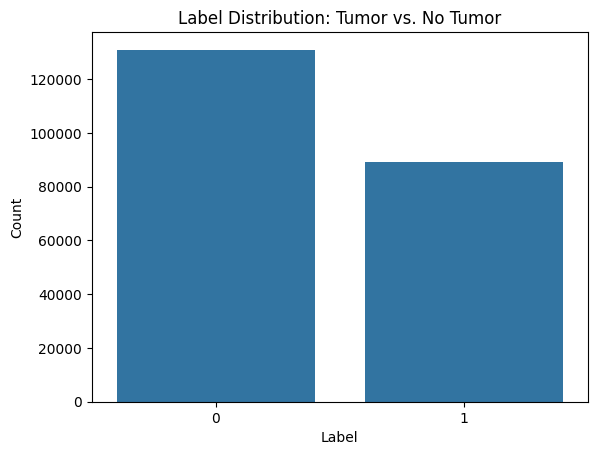

In [44]:

# Check the distribution of labels (Tumor vs. No Tumor)
sns.countplot(x='label', data=train_labels)
plt.title('Label Distribution: Tumor vs. No Tumor')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


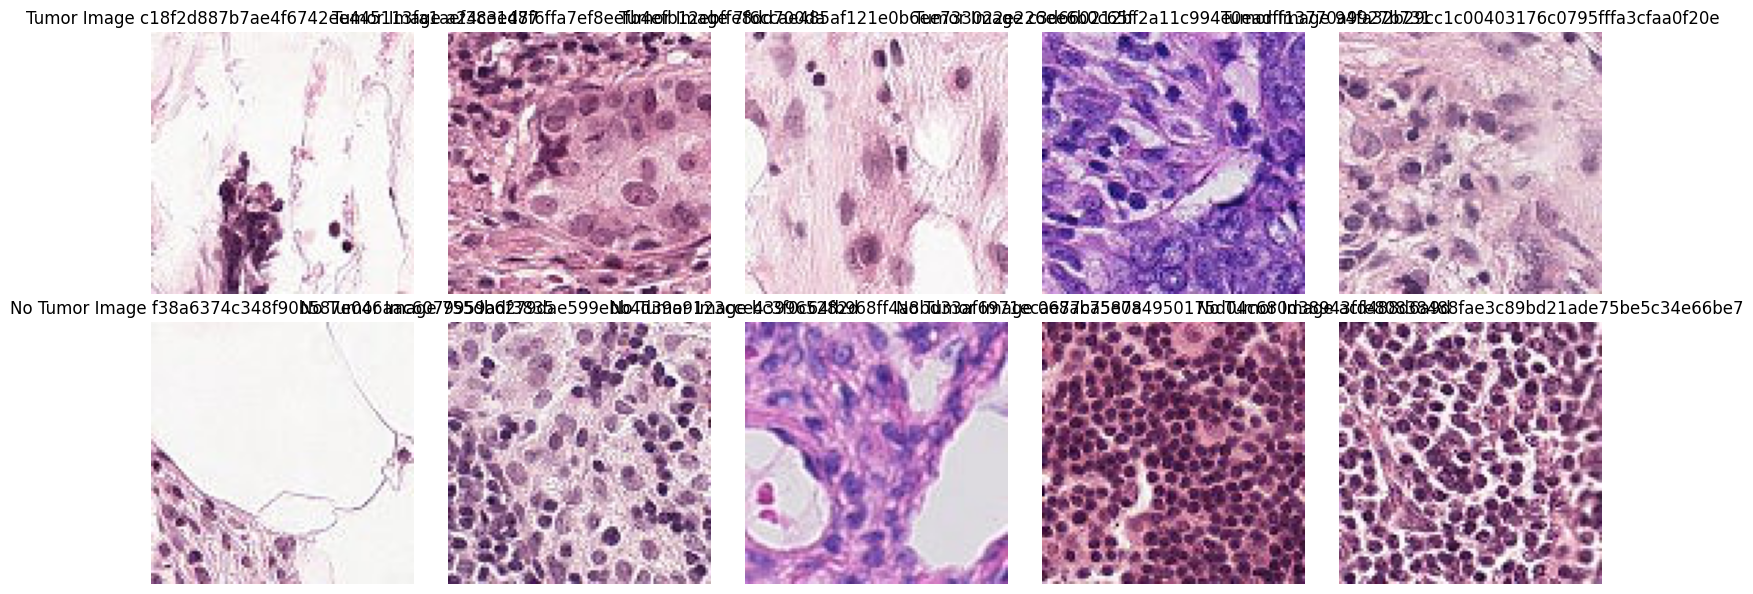

In [45]:
# Visualize sample images from each class (Tumor/No Tumor)
def load_image(image_id):
    image_path = os.path.join(train_images_dir, f'{image_id}.tif')
    img = cv2.imread(image_path)
    return img

def plot_sample_images():
    tumor_ids = train_labels[train_labels['label'] == 1]['id'].values[:5]
    no_tumor_ids = train_labels[train_labels['label'] == 0]['id'].values[:5]
    
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    
    # Plot Tumor Images
    for i, image_id in enumerate(tumor_ids):
        img = load_image(image_id)
        axs[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0, i].set_title(f'Tumor Image {image_id}')
        axs[0, i].axis('off')
    
    # Plot No Tumor Images
    for i, image_id in enumerate(no_tumor_ids):
        img = load_image(image_id)
        axs[1, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[1, i].set_title(f'No Tumor Image {image_id}')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images()

In [46]:
# Analyze image dimensions
image_dimensions = []

for image_id in train_labels['id'].values[:100]:  # Check the first 100 images
    img = load_image(image_id)
    if img is not None:
        image_dimensions.append(img.shape)

image_dimensions = np.array(image_dimensions)

# Display a summary of image dimensions
print("Image Dimension Statistics:")
print(f"Mean dimensions: {np.mean(image_dimensions, axis=0)}")
print(f"Max dimensions: {np.max(image_dimensions, axis=0)}")
print(f"Min dimensions: {np.min(image_dimensions, axis=0)}")

Image Dimension Statistics:
Mean dimensions: [96. 96.  3.]
Max dimensions: [96 96  3]
Min dimensions: [96 96  3]


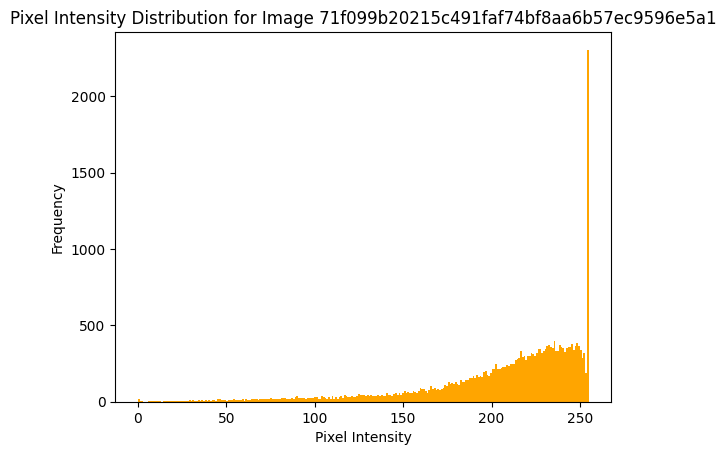

In [48]:
# Inspect pixel intensity distributions for a random image
random_image_id = train_labels['id'].sample(1).values[0]
random_image = load_image(random_image_id)

if random_image is not None:
    plt.hist(random_image.ravel(), bins=256, color='orange', )
    plt.title(f"Pixel Intensity Distribution for Image {random_image_id}")
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()




## Step 3.  Model Architecture

Here we will describe the different model architectures and reasoning for why the specific architecture might be suitable for this problem. 

There are many iterations and tuning of the hyperparameters that have been done outside of this notebook. This one contains 6 combinations of hyperparameters put together in order to increase the accuracy of the predictions. 

After each combination of hyperparameters, the results are submitted to Koggle and the score is collected from their application.

At the end of the section, we will compare the multiple architectures and prepare for the results and conclusions.

In [64]:
# Function to load and preprocess images (crop center 32x32px)
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    # Crop the center 32x32 region
    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    cropped_img = img[center_y - 16:center_y + 16, center_x - 16:center_x + 16]
    return cropped_img

In [52]:
# Load and preprocess all training images
X = []
y = []

for idx, row in train_labels.iterrows():
    image_id = row['id']
    label = row['label']
    image_path = os.path.join(train_images_dir, f'{image_id}.tif')
    processed_image = load_and_preprocess_image(image_path)
    if processed_image is not None:
        X.append(processed_image)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Normalize the image data
X = X / 255.0

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of files
print(f"[INFO] X_train shape: {X_train.shape}")
print(f"[INFO] X_val shape: {X_val.shape}")
print(f"[INFO] y_train shape: {y_train.shape}")
print(f"[INFO] y_val shape: {y_val.shape}")

[INFO] X_train shape: (176020, 32, 32, 3)
[INFO] X_val shape: (44005, 32, 32, 3)
[INFO] y_train shape: (176020,)
[INFO] y_train shape: (176020,)


In [55]:
# Function to load and preprocess test images 
def load_and_preprocess_test_images(test_dir):
    test_images = []
    test_image_ids = []
    
    for file_name in os.listdir(test_dir):
        if file_name.endswith('.tif'):
            image_id = file_name.split('.')[0]
            image_path = os.path.join(test_dir, file_name)
            img = load_and_preprocess_image(image_path)
                
            # Convert image to NumPy array
            img = np.array(img)
                
            # If the image is grayscale, convert to 3D array
            if img.ndim == 2:  
                img = np.expand_dims(img, axis=-1)  # Add channel dimension
                
            test_images.append(img)
            test_image_ids.append(image_id)

    
    # Convert to NumPy array
    test_images = np.array(test_images)
    
    # Normalize the pixel values to be between 0 and 1
    test_images = test_images / 255.0
    
    # Ensure the data type is float32
    test_images = test_images.astype('float32')
    
    return test_images, test_image_ids

# Load and preprocess the test images
X_test, test_image_ids = load_and_preprocess_test_images(test_images_dir)

# Check the shape of X_test to make sure it's (num_images, 32, 32, 3)
print(f"[INFO] X_test shape: {X_test.shape}")


[INFO] X_test shape: (57458, 32, 32, 3)


## MODELS

### 1. Basic CNN Architecture ##

This combination is a good starting point with moderate model complexity and regularization.

Hyperparameters:

Number of Filters: 32, 64, 128

Kernel Size: (3x3)

Activation Function: ReLU

Dropout Rate: 0.3

Batch Size: 32

Learning Rate: 0.001

Weight Regularization: L2(0.001)

Pooling: MaxPooling2D

In [56]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.7515 - loss: 0.5259 - val_accuracy: 0.7994 - val_loss: 0.4540
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.7922 - loss: 0.4641 - val_accuracy: 0.8109 - val_loss: 0.4332
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - accuracy: 0.8052 - loss: 0.4418 - val_accuracy: 0.8127 - val_loss: 0.4298
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.8097 - loss: 0.4321 - val_accuracy: 0.8160 - val_loss: 0.4290
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.8140 - loss: 0.4216 - val_accuracy: 0.8027 - val_loss: 0.4400
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - accuracy: 0.8178 - loss: 0.4157 - val_accuracy: 0.8205 - val_loss: 0.4114
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.8202 - loss: 0.4101 - val_accuracy: 0.8176 - val_loss: 0.4169
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - accuracy: 0.8238 - lo

In [58]:
# Make predictions using the trained model
predictions = model.predict(X_test)

# Convert predictions to binary labels (e.g., threshold of 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Prepare submission DataFrame
submission = pd.DataFrame({
    'id': test_image_ids,
    'label': predicted_labels.flatten()
})

# Save the submission to CSV
submission.to_csv('model-1.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


### Results from Kaggle ##

Score: 0.7826
Private score: 0.7559

### 2. Deep Architecture with Lower Learning Rate 

This setup uses more layers and a lower learning rate, which allows for better fine-tuning on more complex datasets.

Hyperparameters:

Number of Filters: 64, 128, 256

Kernel Size: (3x3)

Activation Function: LeakyReLU

Dropout Rate: 0.4

Batch Size: 64
Learning Rate: 0.0001

Weight Regularization: L2(0.0001)

Pooling: MaxPooling2D

In [59]:
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    Conv2D(64, (3, 3), activation='linear', input_shape=(32, 32, 3), kernel_regularizer=l2(0.0001)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='linear'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='linear'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='linear'),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [60]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 124s 45ms/step - accuracy: 0.7324 - loss: 0.5378 - val_accuracy: 0.7798 - val_loss: 0.4794
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 129s 47ms/step - accuracy: 0.7809 - loss: 0.4771 - val_accuracy: 0.8023 - val_loss: 0.4432
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 125s 45ms/step - accuracy: 0.7996 - loss: 0.4470 - val_accuracy: 0.8117 - val_loss: 0.4235
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 123s 45ms/step - accuracy: 0.8125 - loss: 0.4239 - val_accuracy: 0.8061 - val_loss: 0.4265
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 124s 45ms/step - accuracy: 0.8219 - loss: 0.4057 - val_accuracy: 0.8250 - val_loss: 0.3970
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 123s 45ms/step - accuracy: 0.8323 - loss: 0.3864 - val_accuracy: 0.8335 - val_loss: 0.3853
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 124s 45ms/step - accuracy: 0.8386 - loss: 0.3708 - val_accuracy: 0.8348 - val_loss: 0.3771
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 125s 46ms/step - accuracy: 

In [61]:
# Make predictions using the trained model
predictions = model.predict(X_test)

# Convert predictions to binary labels (e.g., threshold of 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Prepare submission DataFrame
submission = pd.DataFrame({
    'id': test_image_ids,
    'label': predicted_labels.flatten()
})

# Save the submission to CSV
submission.to_csv('model-2.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step


### Results from Kaggle ##

Score: 0.7845
Private score: 0.7689

### 3. Shallower Network for Faster Training##

A lighter model that trains quickly and less likely to create overfitting on smaller datasets.

Hyperparameters:

Number of Filters: 32, 64

Kernel Size: (5x5)

Activation Function: ReLU

Dropout Rate: 0.2

Batch Size: 32

Learning Rate: 0.001

Weight Regularization: None

Pooling: AveragePooling2D

In [62]:
from tensorflow.keras.layers import AveragePooling2D

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    AveragePooling2D(pool_size=(2, 2)),

    Conv2D(64, (5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [63]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 65s 12ms/step - accuracy: 0.7356 - loss: 0.5394 - val_accuracy: 0.7876 - val_loss: 0.4663
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 64s 12ms/step - accuracy: 0.7754 - loss: 0.4849 - val_accuracy: 0.7916 - val_loss: 0.4661
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 64s 12ms/step - accuracy: 0.7877 - loss: 0.4651 - val_accuracy: 0.7833 - val_loss: 0.4765
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.7952 - loss: 0.4530 - val_accuracy: 0.8053 - val_loss: 0.4369
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.8005 - loss: 0.4419 - val_accuracy: 0.8110 - val_loss: 0.4246
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - accuracy: 0.8059 - loss: 0.4304 - val_accuracy: 0.8145 - val_loss: 0.4211
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - accuracy: 0.8128 - loss: 0.4203 - val_accuracy: 0.8091 - val_loss: 0.4372
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - accuracy: 0.8168 -

In [65]:
# Make predictions using the trained model
predictions = model.predict(X_test)

# Convert predictions to binary labels (e.g., threshold of 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Prepare submission DataFrame
submission = pd.DataFrame({
    'id': test_image_ids,
    'label': predicted_labels.flatten()
})

# Save the submission to CSV
submission.to_csv('model-3.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


### Results from Kaggle ##

Score: 0.7924
Private score: 0.7580

## 4. High Dropout for Regularization
As models might be overfitting (training accuracy is much higher than validation accuracy), increasing dropout might help.

Hyperparameters:

Number of Filters: 64, 128, 256

Kernel Size: (3x3)

Activation Function: ReLU

Dropout Rate: 0.5

Batch Size: 32

Learning Rate: 0.0005

Weight Regularization: L2(0.001)

Pooling: MaxPooling2D

In [66]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [67]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 120s 22ms/step - accuracy: 0.7477 - loss: 0.5329 - val_accuracy: 0.7937 - val_loss: 0.4621
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 124s 22ms/step - accuracy: 0.7963 - loss: 0.4581 - val_accuracy: 0.8178 - val_loss: 0.4177
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 120s 22ms/step - accuracy: 0.8079 - loss: 0.4388 - val_accuracy: 0.8151 - val_loss: 0.4208
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 117s 21ms/step - accuracy: 0.8159 - loss: 0.4233 - val_accuracy: 0.8190 - val_loss: 0.4108
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 116s 21ms/step - accuracy: 0.8216 - loss: 0.4069 - val_accuracy: 0.8153 - val_loss: 0.4193
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 118s 22ms/step - accuracy: 0.8311 - loss: 0.3903 - val_accuracy: 0.8184 - val_loss: 0.4121
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 120s 22ms/step - accuracy: 0.8387 - loss: 0.3733 - val_accuracy: 0.8218 - val_loss: 0.4251
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 120s 22ms/step - accuracy: 

In [68]:
# Make predictions using the trained model
predictions = model.predict(X_test)

# Convert predictions to binary labels (e.g., threshold of 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Prepare submission DataFrame
submission = pd.DataFrame({
    'id': test_image_ids,
    'label': predicted_labels.flatten()
})

# Save the submission to CSV
submission.to_csv('model-4.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step


### Results from Kaggle ##

Score: 0.7687
Private score: 0.7353


### 5. Smaller Filter Size for Detailed Feature Extraction##

Smaller filters might help capture fine details in the images, which could improve accuracy.


Hyperparameters:

Number of Filters: 64, 128, 256

Kernel Size: (2x2)

Activation Function: ReLU

Dropout Rate: 0.4

Batch Size: 64

Learning Rate: 0.001

Weight Regularization: L2(0.0001)

Pooling: MaxPooling2D

In [69]:
model = Sequential([
    Conv2D(64, (2, 2), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.0001)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [70]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 94s 34ms/step - accuracy: 0.7520 - loss: 0.5163 - val_accuracy: 0.7966 - val_loss: 0.4470
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 95s 35ms/step - accuracy: 0.8020 - loss: 0.4438 - val_accuracy: 0.8182 - val_loss: 0.4087
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.8126 - loss: 0.4216 - val_accuracy: 0.8256 - val_loss: 0.3960
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 90s 33ms/step - accuracy: 0.8192 - loss: 0.4117 - val_accuracy: 0.8294 - val_loss: 0.3893
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 88s 32ms/step - accuracy: 0.8264 - loss: 0.3975 - val_accuracy: 0.8300 - val_loss: 0.3893
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 88s 32ms/step - accuracy: 0.8303 - loss: 0.3865 - val_accuracy: 0.8338 - val_loss: 0.3802
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 85s 31ms/step - accuracy: 0.8370 - loss: 0.3747 - val_accuracy: 0.8310 - val_loss: 0.3816
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 89s 32ms/step - accuracy: 0.8410 -

In [71]:
# Make predictions using the trained model
predictions = model.predict(X_test)

# Convert predictions to binary labels (e.g., threshold of 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Prepare submission DataFrame
submission = pd.DataFrame({
    'id': test_image_ids,
    'label': predicted_labels.flatten()
})

# Save the submission to CSV
submission.to_csv('model-5.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


### Results from Kaggle ##

Score: 0.7826
Private score: 0.7479


### 6. Shallower Architecture with Larger Filters##

Use larger filters (e.g., 5x5) and fewer layers to learn broader, more general patterns from the input data.

Hyperparameters:

Number of Filters: 32, 64

Kernel Size: (5x5)

Activation Function: ReLU

Dropout Rate: 0.3

Batch Size: 32

Learning Rate: 0.001

Weight Regularization: None

Pooling: MaxPooling2D

In [72]:
model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [73]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 64s 12ms/step - accuracy: 0.7357 - loss: 0.5415 - val_accuracy: 0.7703 - val_loss: 0.4939
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.7754 - loss: 0.4873 - val_accuracy: 0.7920 - val_loss: 0.4590
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.7876 - loss: 0.4677 - val_accuracy: 0.7872 - val_loss: 0.4629
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.7929 - loss: 0.4569 - val_accuracy: 0.7990 - val_loss: 0.4438
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.7942 - loss: 0.4529 - val_accuracy: 0.8018 - val_loss: 0.4347
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.8001 - loss: 0.4456 - val_accuracy: 0.7995 - val_loss: 0.4381
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.8033 - loss: 0.4375 - val_accuracy: 0.7869 - val_loss: 0.4707
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.8029 -

In [74]:
# Make predictions using the trained model
predictions = model.predict(X_test)

# Convert predictions to binary labels (e.g., threshold of 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Prepare submission DataFrame
submission = pd.DataFrame({
    'id': test_image_ids,
    'label': predicted_labels.flatten()
})

# Save the submission to CSV
submission.to_csv('model-6.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


### Results from Kaggle ##

Score: 0.7636
Private score: 0.7399

## Step 4. Results and Analysis

### Models Comparison


**Summary table of the 6 combinations tried**

| Combination | Learning Rate | Dropout Rate | Batch Size | Filters | # Layers | Kernel Size | Score | Private Score |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| 1. Basic CNN Architecture| 0.001 | 0.3| 32 | 32, 64, 128 |128 |3x3 | 0.7826 | 0.7559 |
| 2. Deep Architecture with Lower Learning Rate| 0.0001 | 0.4| 64 | 64, 128, 256 |256 |3x3 | 0.7845 | 0.7689 |
| 3. Shallower Network for Faster Training| 0.001 | 0.2| 32 | 32, 64 |64 |5x5 | 0.7924 | 0.7580 |
| 4. High Dropout for Regularization| 0.0005 | 0.5| 32 |64, 128, 256 |128 |3x3 | 0.7687 | 0.7353 |
| 5. Smaller Filter Size for Detailed Feature Extraction| 0.001 | 0.4| 64 |64, 128, 256 |128 |2x2 | 0.7826 | 0.7479 |
| 6. Shallower Architecture with Larger Filters| 0.001 | 0.3| 32 |32, 64 |64 |5x5 | 0.7636 | 0.7399 |



### Results and analysis

#### Best Performing Combination:

**Combination 3**  (Shallower Network for Faster Training) achieved the highest public score (0.7924) and a private score of 0.7580.
This shows that even with a shallow network and only two layers of filters (32 and 64), the model was able to generalize well. The combination of a medium batch size (32), moderate dropout (0.2), and larger kernel size (5x5) likely contributed to capturing more coarse-grained features.

**Deep Architecture with Lower Learning Rate (Combination 2):**

This setup had the second-highest  public score (0.7845) and the best private score (0.7689).  The lower learning rate (0.0001) likely helped with convergence, but training could have been slower. The higher dropout (0.4) likely helped prevent overfitting in the deeper architecture.

**Basic CNN Architecture (Combination 1):**

Achieved a public score of 0.7826 and a private score of 0.7559. This architecture had a decent performance, likely due to its simplicity. It used a standard setup with a moderate dropout (0.3) and a balanced set of filters (32, 64, 128). However, it didn’t generalize as well as deeper or shallower models.

**High Dropout for Regularization (Combination 4):**

This combination had the lowest public score (0.7687) and private score (0.7353), which indicates that the high dropout rate (0.5) likely introduced too much regularization, leading to underfitting. The learning rate (0.0005) also might have been too low to compensate for the aggressive regularization.
 
**Smaller Filter Size for Detailed Feature Extraction (Combination 5):**

This setup achieved a public score of 0.7826 and a private score of 0.7479. The smaller filter size (2x2) aimed to capture fine-grained details, but it didn’t outperform models with larger filters. This could indicate that the smaller kernel size wasn’t optimal for this task, as it may not have captured broader patterns effectively.

**Shallower Architecture with Larger Filters (Combination 6):**

This combination achieved a public score of 0.7636 and a private score of 0.7399. This shallower network with fewer filters and a larger kernel size (5x5) likely struggled to extract sufficient information, especially with a smaller batch size.


## Step 5. Conclusion

In this project, six different model architectures were tested with varying hyperparameters to classify pathology images for cancer detection. The results revealed key insights into the performance of different combinations of learning rates, dropout rates, batch sizes, filter numbers, and kernel sizes.

The best performing combination in terms of public score was Combination 3 (Shallower Network for Faster Training), achieving a public score of 0.7924. This setup, which used a simple architecture with fewer layers, a moderate dropout rate, and larger filters (5x5), was able to capture essential features efficiently and performed well with a faster training time. However, its private score (0.7580) showed that while it performed well initially, it didn’t generalize as effectively to unseen data.

In contrast, Combination 2 (Deep Architecture with Lower Learning Rate), which employed a deeper network with a lower learning rate and higher dropout, achieved the best private score of 0.7689. This indicates that deeper architectures, with proper regularization, were better at learning more complex patterns and generalizing across datasets.

The key takeaway is that deeper models with lower learning rates and balanced regularization, like Combination 2, tend to generalize better. On the other hand, shallower networks with larger filters, like Combination 3, are faster to train and provide strong initial results, making them suitable for tasks where speed is essential.

Regularization, particularly dropout, needs to be carefully tuned. Overly aggressive dropout (as seen in Combination 4) led to underfitting, while smaller filters (as in Combination 5) missed broader patterns, making them less effective for this task.

In future experiments, balancing depth, dropout, and learning rates will be crucial in optimizing model performance for both accuracy and generalization.
